In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as 

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)


Epoch 1/3
1563/1563 [==============================] - 9s 5ms/step - loss: 0.2909 - accuracy: 0.9137 - val_loss: 0.1537 - val_accuracy: 0.9573
Epoch 2/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1636 - accuracy: 0.9540 - val_loss: 0.1263 - val_accuracy: 0.9669
Epoch 3/3
313/313 [==============================] - 1s 2ms/step


In [4]:
import numpy as np
np.argmax(predictions[0])

7

In [5]:
test_labels[0]

7

In [6]:
(np.argmax(predictions)==test_labels).sum()

1028

In [9]:
# 사용자 정의 평가 지표 => RMSE
import tensorflow as tf


class RootMeanSquaredError(keras.metrics.Metric):
# 연산에 필요한 멤버 변수
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        # 오차 전체 합
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        # 전체합/samples
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")
# override
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)
# override
# 결과 리턴 : RMSE
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))
# override
# 한번의 평가 종료후 멤버변수를 초기화 진행 : 0
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [10]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)


Epoch 1/3
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2936 - accuracy: 0.9136 - rmse: 7.1818 - val_loss: 0.1509 - val_accuracy: 0.9572 - val_rmse: 7.3633
Epoch 2/3
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1659 - accuracy: 0.9533 - rmse: 7.3573 - val_loss: 0.1243 - val_accuracy: 0.9655 - val_rmse: 7.4094
Epoch 3/3
313/313 [==============================] - 1s 4ms/step - loss: 0.1098 - accuracy: 0.9699 - rmse: 7.4287


In [13]:
import datetime

current_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2
    ),
    keras.callbacks.ModelCheckpoint(
        # filepath="checkpoint_path.keras", # 베스트 모델 저장 파일명, .h5
        filepath=f"model_{current_time}_epoch{{epoch:02d}}_val_loss{{val_loss:.2f}}.h5", # 베스트 모델 저장 파일명, .h5
        monitor="val_loss",
        save_best_only=True
    )
]
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))


Epoch 1/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2968 - accuracy: 0.9112 - val_loss: 0.1644 - val_accuracy: 0.9534
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1631 - accuracy: 0.9538 - val_loss: 0.1199 - val_accuracy: 0.9684
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1427 - accuracy: 0.9624 - val_loss: 0.1141 - val_accuracy: 0.9714
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1260 - accuracy: 0.9675 - val_loss: 0.1116 - val_accuracy: 0.9737
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1196 - accuracy: 0.9699 - val_loss: 0.1105 - val_accuracy: 0.9748
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1105 - accuracy: 0.9729 - val_loss: 0.1074 - val_accuracy: 0.9766
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1078 - accuracy: 0.9738 - val_loss: 0.1116 - val_accurac

In [14]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
      if epoch%10 == 0:
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []


Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2917 - accuracy: 0.9134 - val_loss: 0.1485 - val_accuracy: 0.9582
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1660 - accuracy: 0.9539 - val_loss: 0.1171 - val_accuracy: 0.9676
Epoch 3/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.1376 - accuracy: 0.9635 - val_loss: 0.1189 - val_accuracy: 0.9707
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1265 - accuracy: 0.9665 - val_loss: 0.1162 - val_accuracy: 0.9718
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1175 - accuracy: 0.9710 - val_loss: 0.1157 - val_accuracy: 0.9745
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1111 - accuracy: 0.9735 - val_loss: 0.1079 - val_accuracy: 0.9766
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1058 - accuracy: 0.9752 - val_loss: 0.1105 - val_accurac

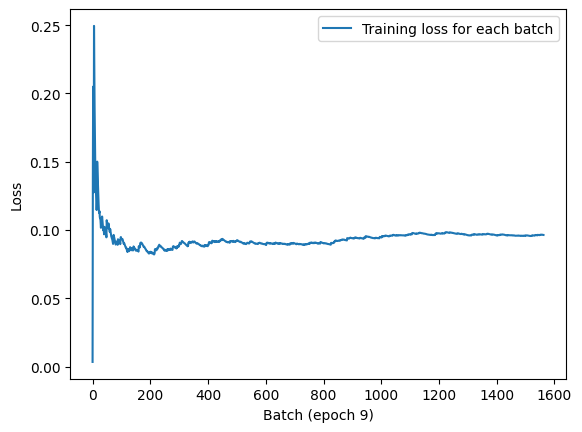

In [15]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))


In [22]:

model = get_mnist_model()

loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()

@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs


In [23]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()


In [24]:

training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"{epoch}번째 에포크 결과")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")


0번째 에포크 결과
...sparse_categorical_accuracy: 0.9138
...loss: 0.2920
1번째 에포크 결과
...sparse_categorical_accuracy: 0.9537
...loss: 0.1669
2번째 에포크 결과
...sparse_categorical_accuracy: 0.9632
...loss: 0.1407


In [20]:
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("평가 결과:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")


평가 결과:
...val_sparse_categorical_accuracy: 0.9680
...val_loss: 0.1279


In [21]:
@tf.function # tensorflow function으로 만들어라
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("평가 결과:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")


평가 결과:
...val_sparse_categorical_accuracy: 0.9680
...val_loss: 0.1279


In [25]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]


In [26]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)


Epoch 1/3
1563/1563 [==============================] - 7s 4ms/step - loss: 0.2961
Epoch 2/3
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1657
Epoch 3/3
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1401


In [27]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}


In [28]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)


Epoch 1/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2947 - sparse_categorical_accuracy: 0.9137
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.9531
Epoch 3/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1412 - sparse_categorical_accuracy: 0.9618
